# Pz estimation from images 

First, this notebook shows where to get the data and the required pre processing. 

Then, it contains the results of the different convolutional models exploration:
- CNN
- ResNet
- DenseNet



In [1]:
import tensorflow as tf

#Checking for GPU access
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#tools contains different useful functions (plot results, calculate metrics, etc.)
from tools import *

# 1. Data preprocessing

The main datafile is the one called 'download'. It contains a collection of galaxy images associated with a catalogue of features (including the redshift). 
The two other file 'img_30k.npy' and 'z_30k.npy' are just an extracted subset of the 'download' fulldata set for easier manipulation.  

In [3]:
# data is stored in the following repo
%ls /global/cfs/cdirs/lsst/groups/PZ/valentin_image_data_temp

download  img_30k.npy  z_30k.npy


In [4]:
data = np.load('/global/cfs/cdirs/lsst/groups/PZ/valentin_image_data_temp/download')

In [5]:
type(data)

numpy.lib.npyio.NpzFile

In [6]:
data.files

['labels', 'cube']

### Labels

'labels' is a big catalogue containing multiple features for each galawy images

In [7]:
# let's extract the first 30k lines and create a Dataframe with them
cat = pd.DataFrame(data["labels"][:30000] )
cat.head()

,imageID,specObjID,bestObjID,class,subClass,z,zErr,objID,type,flags,...,expPhi_r,petroR90_r,deVRad_r,expRad_r,probPSF_r,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z
0,0,468485993301829632,1237645879579967591,b'GALAXY ',b' ',0.131836,0.000034,1237645879579967591,3,68987912192,...,119.843643,5.452299,2.688046,1.774538,0.0,0.607155,0.446739,0.324012,0.245689,0.174196
1,1,461778147604457472,1237645943973609618,b'GALAXY ',b' ',0.074451,0.000023,1237645943973609618,3,68987912704,...,112.516106,3.505879,1.390237,1.181563,0.0,0.423589,0.311672,0.226051,0.171408,0.121530
2,2,1758799466837600256,1237645943973609651,b'GALAXY ',b'STARBURST ',0.109586,0.000008,1237645943973609651,3,103347650560,...,111.944115,3.128703,1.997813,1.203557,0.0,0.439628,0.323474,0.234610,0.177898,0.126132
3,3,1758810736831784960,1237645943973675206,b'GALAXY ',b'STARBURST ',0.297891,0.000011,1237645943973675206,3,35255507619856,...,71.323067,2.764292,0.866695,0.670234,0.0,0.446042,0.328193,0.238033,0.180493,0.127972
4,4,1763250014206846976,1237645943976493341,b'GALAXY ',b' ',0.588741,0.000129,1237645943976493341,3,105622104178960,...,115.410812,2.409743,0.774804,0.630463,0.0,0.626639,0.461075,0.334410,0.253573,0.179786


In [8]:
z = cat.z

In [9]:
cat.z.min(), cat.z.max()

(0.00018725298, 0.6976703)

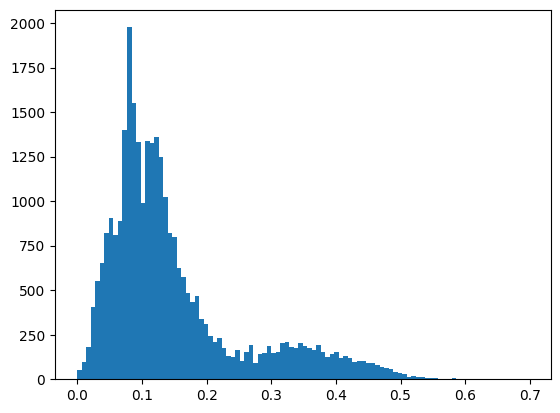

In [10]:
plt.hist(cat.z, bins=100);

Redshifts are relatively low in this dataset: 0 < z < 0.7

### Cube

'cube' contains all galaxy images

In [11]:
images = data['cube'][:30000]

In [12]:
images.shape

(30000, 64, 64, 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


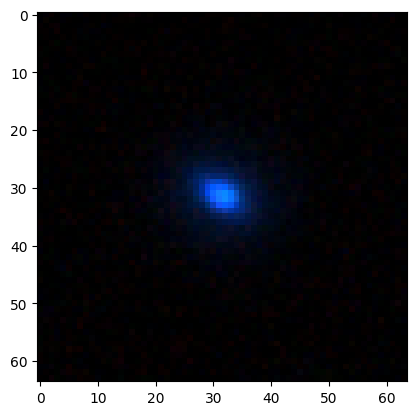

In [13]:
# To check the images, 3 channels and not 5 are required, hence the :3 at the end
plt.imshow(images[0, :, :,:3])
plt.show();

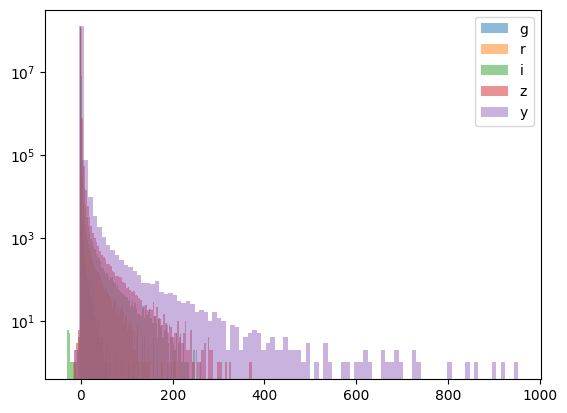

In [14]:
# Checl the distribution of each channels
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
    plt.hist(images[...,i].flatten(), 100, label=b, alpha=0.5)
    plt.yscale('log');
    plt.legend()

Need to standardize the data.
The following data processing is the one proposed by [Francois Lanusse here.](https://github.com/EiffL/Tutorials/blob/master/PhotozCNN/photoz_inference_training_solution.ipynb)

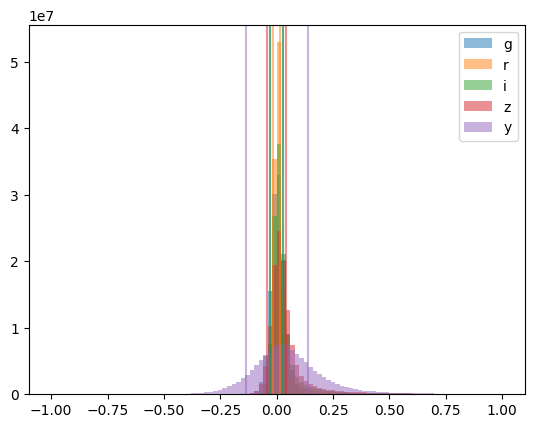

In [15]:
# Let's evaluate the noise standard deviation in each band, and apply range compression accordingly
from astropy.stats import mad_std
scaling = []
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
    plt.hist(images[...,i].flatten(), 100, label=b, alpha=0.5, range=[-1,1]);
    sigma = mad_std(images[...,i].flatten())
    scaling.append(sigma)
    plt.axvline(sigma, color='C%d'%i,alpha=0.5)
    plt.axvline(-sigma, color='C%d'%i,alpha=0.5)
    plt.legend()

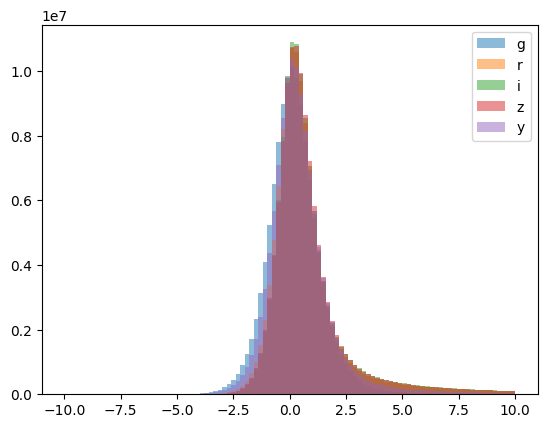

In [16]:
# Let's have a look at this distribution if we rescale each band by the standard deviation
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
    plt.hist(images[...,i].flatten()/scaling[i],100, label=b,alpha=0.5, range=[-10,10]);
    plt.legend()

In [17]:
def preprocessing(image):
    return np.arcsinh(image / scaling / 3. )

In [18]:
prepro_img = preprocessing(images)

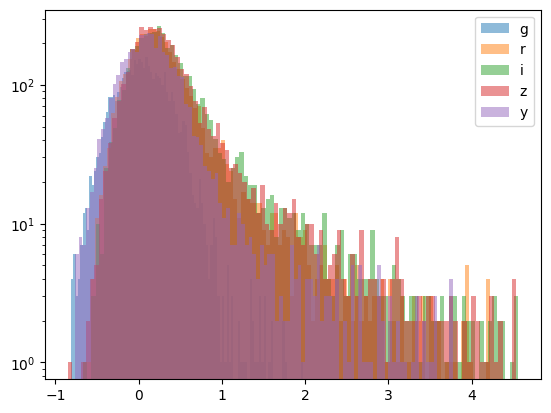

In [19]:
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
    plt.hist(tf.reshape(prepro_img[1000, :, :,i], -1), 100, label=b, alpha=0.5)
    plt.yscale('log');
plt.legend()

### Train val test split 

In [20]:
# Split into train and test
img_train = prepro_img[:15000,...]
img_val = prepro_img[15000:20000,...]
img_test = prepro_img[20000:, ...]

z_train = z[:15000]
z_val = z[15000:20000]
z_test = z[20000:]

In [21]:
img_train.shape

(15000, 64, 64, 5)

# 2. CNN model

In [22]:
import tensorflow.keras as tfk

def create_model():
    model = tfk.models.Sequential()
    
    model.add(tfk.layers.Conv2D(32, kernel_size=5, padding='same', input_shape=(64,64,5), activation='elu', strides=2))
    model.add(tfk.layers.BatchNormalization())

    model.add(tfk.layers.Conv2D(64, kernel_size=3, padding='same', activation='elu'))
    model.add(tfk.layers.BatchNormalization())

    model.add(tfk.layers.Conv2D(128, kernel_size=3, padding='same', strides=2, activation='elu'))
    model.add(tfk.layers.BatchNormalization())  

    model.add(tfk.layers.Conv2D(256, kernel_size=3, padding='same', activation='elu', strides=2))
    model.add(tfk.layers.BatchNormalization())

    model.add(tfk.layers.Conv2D(512, kernel_size=3, padding='same', activation='elu', strides=2))
    model.add(tfk.layers.BatchNormalization())
    
    # remplacer flatten par global pooling potentiellment moins d'overfit
    model.add(tfk.layers.Flatten())
    model.add(tfk.layers.Dense(512))
    model.add(tfk.layers.Activation('relu'))
    model.add(tfk.layers.Dense(256))
    model.add(tfk.layers.Activation('relu'))
    model.add(tfk.layers.Dense(1))

    model.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
                loss=tfk.metrics.mse)
    return model

In [23]:
model = create_model()

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        4032      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization_2 (Batc  (None, 16, 16, 128)      5

In [25]:
# Learning rate schedule
LEARNING_RATE=0.001
LEARNING_RATE_EXP_DECAY=1
lr_decay = tfk.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch)

# Tensoboard tracking
#tb_callback = tf.keras.callbacks.TensorBoard('./logs/CNN', update_freq='batch')

# Early_stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, 
                                              restore_best_weights=True)

history_cnn = model.fit(x = img_train, 
          y = z_train,
          batch_size = 64,
          validation_data=(img_val, z_val),
          steps_per_epoch=len(img_train)//64,
          epochs=50,
          callbacks=[lr_decay, early_stop])

Epoch 1/50
234/234 [==============================] - 7s 8ms/step - loss: 0.4447 - val_loss: 0.0047 - lr: 0.0010
Epoch 2/50
234/234 [==============================] - 1s 5ms/step - loss: 0.0052 - val_loss: 0.0033 - lr: 0.0010
Epoch 3/50
234/234 [==============================] - 1s 5ms/step - loss: 0.0035 - val_loss: 0.0043 - lr: 0.0010
Epoch 4/50
234/234 [==============================] - 1s 5ms/step - loss: 0.0028 - val_loss: 0.0059 - lr: 0.0010
Epoch 5/50
234/234 [==============================] - 1s 5ms/step - loss: 0.0027 - val_loss: 0.0037 - lr: 0.0010
Epoch 6/50
234/234 [==============================] - 1s 5ms/step - loss: 0.0030 - val_loss: 0.0024 - lr: 0.0010
Epoch 7/50
234/234 [==============================] - 1s 5ms/step - loss: 0.0015 - val_loss: 0.0027 - lr: 0.0010
Epoch 8/50
234/234 [==============================] - 1s 6ms/step - loss: 0.0017 - val_loss: 0.0028 - lr: 0.0010
Epoch 9/50
234/234 [==============================] - 1s 5ms/step - loss: 0.0013 - val_loss: 0.0

In [26]:
# Get the prediction
preds = model.predict(img_test)

313/313 [==============================] - 1s 2ms/step


In [27]:
# Metrics results
dz, pred_bias, smad, out_frac = metrics(z_test, preds.squeeze())
print_metrics(pred_bias, smad, out_frac)

Prediction bias: 0.0046


<IPython.core.display.Latex object>

Outlier fraction: 9.98%


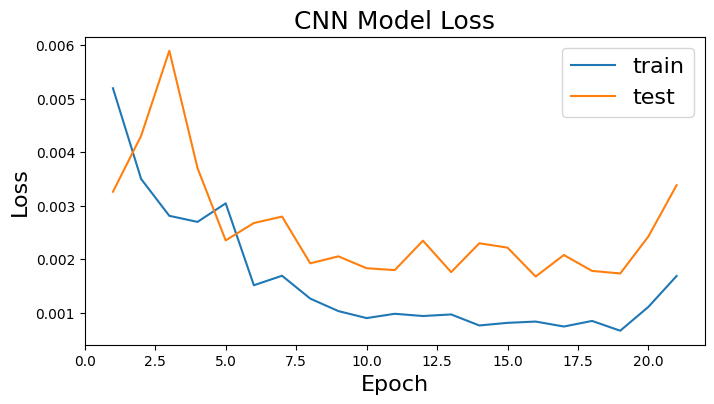

In [28]:
history_plot(history_cnn, 'CNN Model Loss')

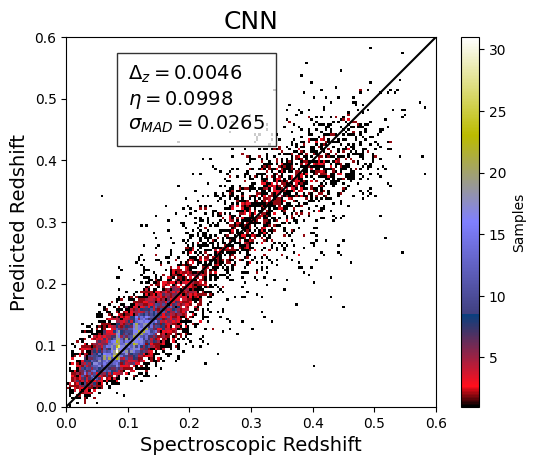

In [29]:
plot_results(z_test, preds.squeeze(), pred_bias, out_frac, smad, 'CNN')

# 3. ResNet

In [30]:
from tensorflow.keras.applications import ResNet50

def resnet_model():

    model = tfk.models.Sequential()

    model.add(ResNet50(include_top = False,
                     pooling = 'avg',
                     input_shape=(64,64,5),
                     weights=None))

    model.add(tfk.layers.Flatten())
    model.add(tfk.layers.Dense(512))
    model.add(tfk.layers.Activation('relu'))
    model.add(tfk.layers.Dense(256))
    model.add(tfk.layers.Activation('relu'))
    model.add(tfk.layers.Dense(1))

    model.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
                loss=tfk.metrics.mse)
    return model

In [31]:
model_resnet = resnet_model()

model_resnet.summary()

/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/applications/resnet.py:135: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 5 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23593984  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               1049088   
                                                                 
 activation_2 (Activation)   (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 activation_3 (Activation)   (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [32]:
%%time
# Learning rate schedule
LEARNING_RATE=0.001
LEARNING_RATE_EXP_DECAY=0.9
lr_decay = tfk.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

# Tensoboard tracking
#tb_callback = tf.keras.callbacks.TensorBoard('./logs/ResNet', update_freq='batch')

# Early_stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, 
                                              restore_best_weights=True)

history_resnet = model_resnet.fit(x = img_train, 
          y = z_train,
          batch_size = 64,
          validation_data=(img_val, z_val),
          steps_per_epoch=len(img_train)//64,
          epochs=50,
          callbacks=[lr_decay])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50
234/234 [==============================] - 10s 28ms/step - loss: 0.8570 - val_loss: 0.0069 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/50
234/234 [==============================] - 6s 24ms/step - loss: 0.0139 - val_loss: 0.0028 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/50
234/234 [==============================] - 6s 24ms/step - loss: 0.0053 - val_loss: 0.0027 - lr: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/50
234/234 [==============================] - 6s 24ms/step - loss: 0.0051 - val_loss: 0.0036 - lr: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/50
234/234 [==============================] - 6s 26ms/step - loss: 0.0032 - val_loss: 0.0048 - lr: 6.5610e-04

Epoch 6: LearningRateSchedul

In [33]:
# Get the prediction
resnet_preds = model_resnet.predict(img_test).squeeze()

313/313 [==============================] - 3s 6ms/step


In [34]:
# Metrics results
dz, pred_bias, smad, out_frac = metrics(z_test, resnet_preds)
print_metrics(pred_bias, smad, out_frac)

Prediction bias: -0.0071


<IPython.core.display.Latex object>

Outlier fraction: 12.06%


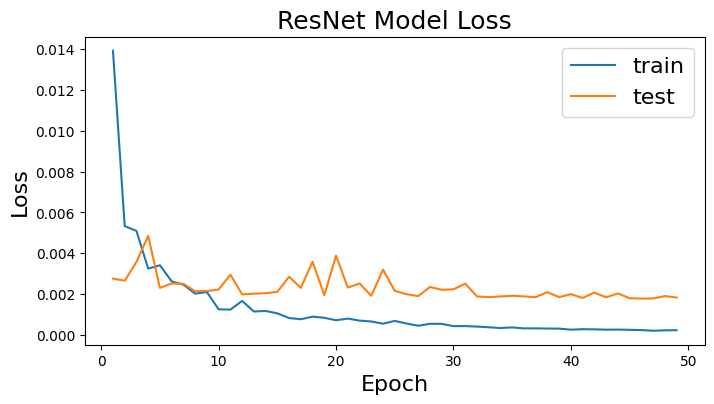

In [35]:
history_plot(history_resnet, 'ResNet Model Loss')

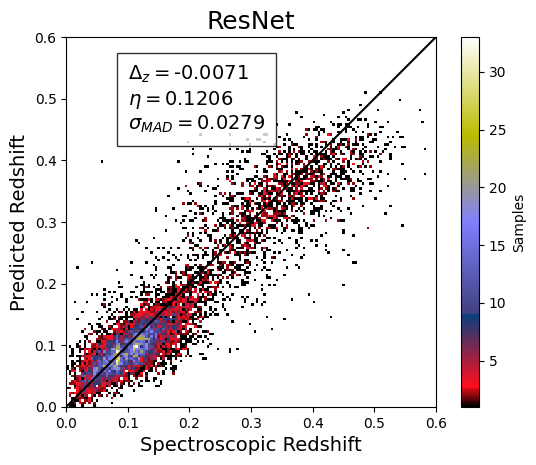

In [36]:
plot_results(z_test, resnet_preds, pred_bias, out_frac, smad, 'ResNet')

# 4. DenseNet

In [37]:
from tensorflow.keras.applications import DenseNet121

def densenet_model():

    model = tfk.models.Sequential()

    model.add(DenseNet121(include_top = False,
                     pooling = 'avg',
                     input_shape=(64,64,5),
                     weights=None))

    model.add(tfk.layers.Flatten())
    model.add(tfk.layers.Dense(512))
    model.add(tfk.layers.Activation('relu'))
    model.add(tfk.layers.Dense(256))
    model.add(tfk.layers.Activation('relu'))
    model.add(tfk.layers.Dense(1))

    model.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
                loss=tfk.metrics.mse)
    return model

In [38]:
model_densenet = densenet_model()

model_densenet.summary()

/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/applications/densenet.py:210: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 5 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7043776   
                                                                 
 flatten_2 (Flatten)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 activation_4 (Activation)   (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 activation_5 (Activation)   (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                

In [39]:
%%time
# Learning rate schedule
LEARNING_RATE=0.001
LEARNING_RATE_EXP_DECAY=0.9
lr_decay = tfk.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

# Tensoboard tracking
#tb_callback = tf.keras.callbacks.TensorBoard('./logs/DenseNet', update_freq='batch')


# Early_stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, 
                                              restore_best_weights=True)

history_dense = model_densenet.fit(x = img_train, 
          y = z_train,
          batch_size = 64,
          validation_data=(img_val, z_val),
          steps_per_epoch=len(img_train)//64,
          epochs=50,
          callbacks=[lr_decay, early_stop])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50
234/234 [==============================] - 19s 52ms/step - loss: 0.0963 - val_loss: 0.0029 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/50
234/234 [==============================] - 11s 45ms/step - loss: 0.0034 - val_loss: 0.0027 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/50
234/234 [==============================] - 10s 44ms/step - loss: 0.0026 - val_loss: 0.0102 - lr: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/50
234/234 [==============================] - 11s 48ms/step - loss: 0.0019 - val_loss: 0.0025 - lr: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/50
234/234 [==============================] - 11s 48ms/step - loss: 0.0017 - val_loss: 0.0017 - lr: 6.5610e-04

Epoch 6: LearningRateSch

In [40]:
# Get the prediction
densenet_preds = model_densenet.predict(img_test).squeeze()

313/313 [==============================] - 5s 13ms/step


In [41]:
# Metrics results
dz, pred_bias, smad, out_frac = metrics(z_test, densenet_preds)
print_metrics(pred_bias, smad, out_frac)

Prediction bias: -0.0032


<IPython.core.display.Latex object>

Outlier fraction: 6.15%


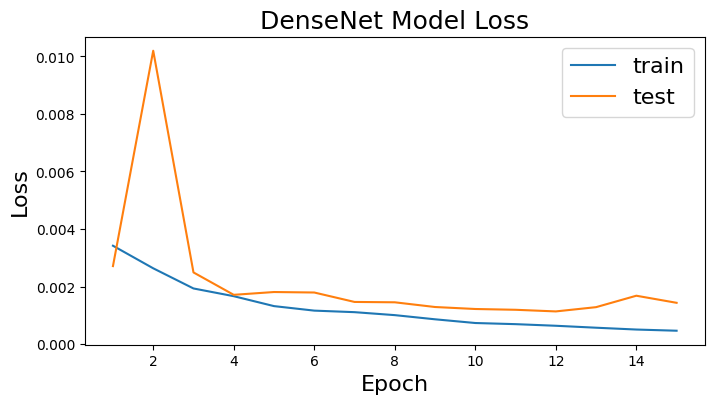

In [42]:
history_plot(history_dense, 'DenseNet Model Loss')

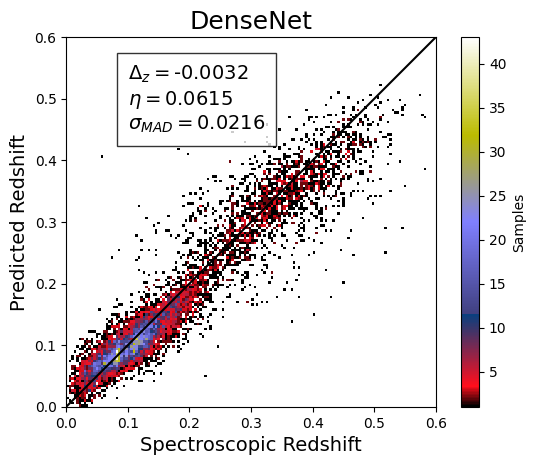

In [43]:
plot_results(z_test, densenet_preds, pred_bias, out_frac, smad, 'DenseNet')